In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
import requests
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
import re
from IPython.display import display

### Part 0: Load Data

In [294]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/data/inferred_genres.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres.drop(columns="title"), how="left", on="book_id")

In [295]:
df_inferred_genres

,book_id,title,main_genre,Genre_1,Genre_2,Genre_3,Genre_4,Genre_5,Genre_6,Genre_7,...,Genre_11,Genre_12,Genre_13,Genre_14,Genre_15,Genre_16,Genre_17,Genre_18,Genre_19,Genre_20
0,6066819,Best Friends Forever,18,0.007954,0.007954,0.007954,0.007954,0.007954,0.007954,0.007954,...,0.007954,0.007954,0.007954,0.007954,0.007954,0.007954,0.007954,0.848865,0.007954,0.007954
1,287149,The Devil's Notebook,5,0.012184,0.012184,0.153330,0.012184,0.627366,0.012184,0.012184,...,0.012184,0.012184,0.012184,0.012184,0.012184,0.012184,0.012184,0.012184,0.012184,0.012184
2,6066814,"Crowner Royal (Crowner John Mystery, #13)",19,0.007840,0.007840,0.007840,0.007840,0.007840,0.007840,0.007840,...,0.007840,0.007840,0.007840,0.007840,0.007840,0.007840,0.402096,0.007840,0.456792,0.007840
3,89375,90 Minutes in Heaven: A True Story of Death an...,18,0.008310,0.008310,0.008310,0.008310,0.008310,0.008310,0.008310,...,0.008310,0.008310,0.008310,0.008310,0.008310,0.008310,0.008310,0.615330,0.008310,0.008310
4,89376,Heaven,5,0.005709,0.005709,0.005709,0.005709,0.529572,0.005709,0.005709,...,0.005709,0.005709,0.005709,0.005709,0.005709,0.367671,0.005709,0.005709,0.005709,0.005709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314914,7195902,The Short Happy Life of Francis Macomber,6,0.016865,0.016865,0.016865,0.016865,0.016865,0.679560,0.016865,...,0.016865,0.016865,0.016865,0.016865,0.016865,0.016865,0.016865,0.016865,0.016865,0.016865
314915,31522515,Walking on My Grave,19,0.006613,0.006613,0.006613,0.006613,0.006613,0.006613,0.006613,...,0.006613,0.006613,0.006613,0.006613,0.006613,0.006613,0.006613,0.006613,0.874350,0.006613
314916,15500943,"Not Quickly Broken (Chop, Chop, #7)",15,0.008824,0.008824,0.008824,0.008824,0.008824,0.008824,0.008824,...,0.008824,0.008824,0.008824,0.008824,0.832336,0.008824,0.008824,0.008824,0.008824,0.008824
314917,1370179,The Brazilian Boss's Innocent Mistress,1,0.842573,0.008286,0.008286,0.008286,0.008286,0.008286,0.008286,...,0.008286,0.008286,0.008286,0.008286,0.008286,0.008286,0.008286,0.008286,0.008286,0.008286


In [296]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [297]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/data/goodreads_library_export.csv")

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating"]].rename(columns={"Book Id":"book_id", "My Rating":"rating"}).query("rating > 0")

# Reformat to fit sparse matrix
my_books = pd.merge(book_index, my_books, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])

# Replace 0 with 0.1 to prevent cosine similarities from zeroing
sparse_fill = 0.001
df_reviews.data[df_reviews.data == 0] = sparse_fill

### Part 1: Find Similar Users

In [298]:
### NOT WORKING AS EXPECTED -- NEED TO FIX

# Normalize reviews within users
norm = Normalizer()
df_reviews = norm.fit_transform(df_reviews) 

In [321]:
# Instantiate KNN
n_neighbors = 75
target_user = df_reviews.shape[0] - 1

nn_model = NearestNeighbors(
    metric="cosine",
    algorithm="auto",
    n_neighbors=n_neighbors,
    n_jobs=-1
)

# Fit to sparse matrix
nn_model.fit(df_reviews)

# Feed in user and get neighbors and distances
reader = df_reviews[target_user,:].toarray()
dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

similar_users = pd.DataFrame(
    [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(columns={0:"user", 1:"distance"}
)

similar_users.head()

,user,distance
0,245119.0,0.000000
1,68871.0,0.804018
2,169157.0,0.809443
3,242451.0,0.827690
4,147443.0,0.831460


In [322]:
# Get all books read by similar users
book_ind = []
book_rat = []
uid = []
target_user_books = []
target_user_book_rat = []
for nt in similar_users.itertuples():
    user = df_reviews[int(nt.user),:].toarray()
    book_inds = np.where(user[0] > 0)[0]
    ratings = user[0][np.where(user[0] > 0)[0]]
    for i in range(len(book_inds)):        
        book_ind.append(book_inds[i])
        book_rat.append(ratings[i])
        uid.append(nt.user)    
        if nt.distance < 0.000000001:
            target_user_books.append(book_inds[i])
            target_user_book_rat.append(ratings[i])

neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(columns={0:"uid",1:"book_index",2:"user_rating"})

# Join overall rating for each book
neighbor_user_ratings = pd.merge(book_index.reset_index(), neighbor_user_ratings, how="inner", left_on="index", right_on="book_index")
neighbor_user_ratings = pd.merge(neighbor_user_ratings, df_books, how="inner", on="book_id")

# Filter out books target reader has already read
neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
neighbor_user_ratings.drop(["index", "book_index"], axis=1, inplace=True)

# Filter out later volumes in series using regex pattern
regex = r"#([2-9]|[1-9]\d+)"
neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex)]

# Weight user book rating by cosine similarity

# Average weighted user book rating and overall avg rating

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_43473/3760903270.py:31: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex)]


In [323]:
# View neighbors rating table
neighbor_user_ratings.head()

,book_id,uid,user_rating,title,avg_rating,ratings_count,year,language_code,image_url,url,...,Genre_11,Genre_12,Genre_13,Genre_14,Genre_15,Genre_16,Genre_17,Genre_18,Genre_19,Genre_20
0,100915,83359.0,0.267860,"The Lion, the Witch, and the Wardrobe (Chronic...",4.19,1575387.0,2005,eng,https://images.gr-assets.com/books/1353029077m...,https://www.goodreads.com/book/show/100915.The...,...,0.009122,0.009122,0.009122,0.009122,0.009122,0.826681,0.009122,0.009122,0.009122,0.009122
1,10127019,149314.0,0.114992,The Lean Startup: How Today's Entrepreneurs Us...,4.04,95622.0,2011,en-US,https://images.gr-assets.com/books/1333576876m...,https://www.goodreads.com/book/show/10127019-t...,...,0.006269,0.006269,0.006269,0.006269,0.006269,0.006269,0.006269,0.006269,0.006269,0.006269
2,10193060,122168.0,0.248452,Miserere: An Autumn Tale,3.79,747.0,2011,eng,https://images.gr-assets.com/books/1301084223m...,https://www.goodreads.com/book/show/10193060-m...,...,0.007666,0.007666,0.007666,0.007666,0.007666,0.007666,0.854340,0.007666,0.007666,0.007666
3,10245518,133863.0,0.158986,The Checklist Manifesto How to Get Things Right,4.03,268.0,2011,eng,https://images.gr-assets.com/books/1356488549m...,https://www.goodreads.com/book/show/10245518-t...,...,0.005871,0.005871,0.005871,0.005871,0.005871,0.005871,0.005871,0.005871,0.005871,0.005871
4,10321016,204297.0,0.368230,Pitch Anything: An Innovative Method for Prese...,4.09,4346.0,2011,NaN,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/10321016-p...,...,0.007005,0.007005,0.007005,0.007005,0.007005,0.007005,0.007005,0.007005,0.007005,0.007005


In [324]:
# View target user's ratings
target_user_ratings = pd.DataFrame([target_user_books, target_user_book_rat]).T.rename(columns={0:"book_index",1:"user_rating"})
target_user_ratings = pd.merge(book_index.reset_index(), target_user_ratings, how="inner", left_on="index", right_on="book_index")
target_user_ratings = pd.merge(target_user_ratings, df_books, how="inner", on="book_id")
target_user_ratings.head(10)

,index,book_id,book_index,user_rating,title,avg_rating,ratings_count,year,language_code,image_url,...,Genre_11,Genre_12,Genre_13,Genre_14,Genre_15,Genre_16,Genre_17,Genre_18,Genre_19,Genre_20
0,159556,12352452,159556.0,0.084853,"Season of the Witch: Enchantment, Terror and D...",4.22,2481.0,2012,NaN,https://images.gr-assets.com/books/1329324459m...,...,0.004979,0.004979,0.004979,0.004979,0.004979,0.004979,0.004979,0.004979,0.004979,0.004979
1,222333,13166586,222333.0,0.084853,The Fish That Ate the Whale: The Life and Time...,3.97,1497.0,2012,eng,https://images.gr-assets.com/books/1327473440m...,...,0.005590,0.005590,0.005590,0.005590,0.005590,0.005590,0.005590,0.005590,0.005590,0.005590
2,270440,13554058,270440.0,0.084853,The Wandering Earth,4.01,894.0,2012,eng,https://images.gr-assets.com/books/1332444998m...,...,0.008574,0.008574,0.008574,0.008574,0.008574,0.342984,0.502676,0.008574,0.008574,0.008574
3,340694,15195,340694.0,0.113137,"The Complete Maus (Maus, #1-2)",4.53,79457.0,2003,en-GB,https://images.gr-assets.com/books/1327354180m...,...,0.008383,0.008383,0.008383,0.008383,0.008383,0.008383,0.008383,0.008383,0.008383,0.008383
4,442607,16256798,442607.0,0.056569,The One Thing: The Surprisingly Simple Truth B...,4.15,15237.0,2013,eng,https://images.gr-assets.com/books/1362177469m...,...,0.011160,0.011160,0.011160,0.011160,0.011160,0.011160,0.011160,0.011160,0.011160,0.011160
5,562115,17987621,562115.0,0.084853,The Entrepreneurial State: Debunking Public vs...,3.89,358.0,2013,NaN,https://images.gr-assets.com/books/1369818314m...,...,0.006270,0.006270,0.006270,0.006270,0.006270,0.006270,0.006270,0.006270,0.006270,0.006270
6,568445,18050143,568445.0,0.056569,"Zero to One: Notes on Startups, or How to Buil...",4.17,52400.0,2014,eng,https://images.gr-assets.com/books/1414347376m...,...,0.005932,0.005932,0.005932,0.005932,0.005932,0.005932,0.005932,0.005932,0.005932,0.005932
7,623534,18490568,623534.0,0.084853,"Age of Ambition: Chasing Fortune, Truth, and F...",4.23,3432.0,2014,eng,https://images.gr-assets.com/books/1418113377m...,...,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558,0.005558
8,657155,18778874,657155.0,0.056569,The Second Amendment,4.01,430.0,2014,eng,https://images.gr-assets.com/books/1397767878m...,...,0.006369,0.006369,0.006369,0.006369,0.006369,0.006369,0.006369,0.006369,0.006369,0.006369
9,754447,20588662,754447.0,0.084853,An Indigenous Peoples' History of the United S...,4.27,1225.0,2014,NaN,https://images.gr-assets.com/books/1395003842m...,...,0.006964,0.006964,0.006964,0.006964,0.006964,0.006964,0.006964,0.006964,0.006964,0.006964


In [325]:
# 20 most popular books among similar readers
popular_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
    .nlargest(20, "book_id").rename(columns={"book_id":"percent_similar_users_read"})

popular_recs["percent_similar_users_read"] = (popular_recs["percent_similar_users_read"] / n_neighbors).map('{:.1%}'.format)

popular_recs

,title,avg_rating,ratings_count,year,percent_similar_users_read
226,The Gunslinger,3.98,346978.0,1982,5.3%
186,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0,1997,4.0%
131,Ninefox Gambit (The Machineries of Empire #1),3.91,3425.0,2016,4.0%
100,Judas Unchained,4.30,21306.0,2005,2.7%
13,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0,2016,2.7%
300,"Wool Omnibus (Silo, #1)",4.24,83601.0,2012,2.7%
221,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0,2013,2.7%
77,"Gateway (Heechee Saga, #1)",4.07,30282.0,2004,2.7%
157,"Ringworld (Ringworld, #1)",3.96,78483.0,2005,2.7%
231,The Hike,3.92,5603.0,2016,2.7%


In [326]:
# 10 highest rated books among similar readers
highest_rated_recs = neighbor_user_ratings.groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
    .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
    .nlargest(20, "avg_rating").rename(columns={"book_id":"percent_similar_users_read"})

highest_rated_recs["percent_similar_users_read"] = highest_rated_recs["percent_similar_users_read"] / n_neighbors

for i in range(n_neighbors,-1,-1):
    results = highest_rated_recs.query("percent_similar_users_read > (@i / @n_neighbors)")    
    if len(results) >= 10:
        print(i)
        break

results

0


,title,avg_rating,ratings_count,year,percent_similar_users_read
264,The Story of Human Language,4.44,394.0,2004,0.013333
273,"The Walking Dead, Compendium 1",4.43,58434.0,2009,0.013333
104,"Kings of the Wyld (The Band, #1)",4.42,2285.0,2017,0.013333
10,Adventure Time With Fionna and Cake,4.41,2542.0,2013,0.013333
54,David Attenborough's Life on Air: Memoirs of a...,4.39,1836.0,2003,0.013333
28,"Berserk, Vol. 1 (Berserk, #1)",4.38,10778.0,2003,0.013333
242,The Looming Tower: Al-Qaeda and the Road to 9/11,4.38,13019.0,2006,0.013333
85,Homicide: A Year on the Killing Streets,4.37,10487.0,1991,0.013333
164,"Senlin Ascends (The Books of Babel, #1)",4.37,1410.0,2013,0.013333
202,The Complete Works of H.P. Lovecraft,4.34,9733.0,2011,0.013333


In [327]:
# Best recommendations based on rating, popularity, and user similarity


In [328]:
# Filter recommendations by genre, year, popularity

In [329]:
# Recs filtered by genre

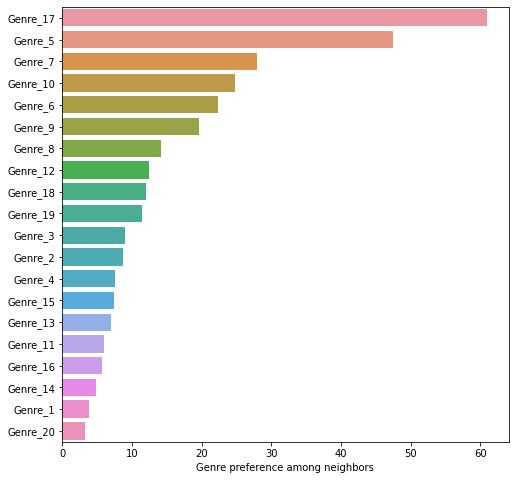

In [330]:
# Find top genres
fig, ax = plt.subplots(figsize=(8,8))
genre_ranking = pd.DataFrame(neighbor_user_ratings.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
sns.barplot(
    data=genre_ranking,
    y=genre_ranking.index,
    x=0
)
plt.xlabel("Genre preference among neighbors")
plt.show()

In [332]:
# Loop through genres in descending relevance order and print top 5 recs
for genre in genre_ranking.index:
    
    g = float(genre[6:])
    highest_rated_recs_genre = neighbor_user_ratings.query("main_genre == @g")\
        .groupby(["title", "avg_rating", "ratings_count", "year"])["book_id"]\
        .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)\
        .rename(columns={"book_id":"percent_similar_users_read"})

    highest_rated_recs_genre["percent_similar_users_read"] = highest_rated_recs_genre["percent_similar_users_read"] / n_neighbors
    highest_rated_recs_genre = highest_rated_recs_genre.query("ratings_count > 400")

    print(genre)
    display(highest_rated_recs_genre[["title", "avg_rating", "ratings_count"]].head(10))
    print("_____\n")

Genre_17


,title,avg_rating,ratings_count
21,"Kings of the Wyld (The Band, #1)",4.42,2285.0
4,"Berserk, Vol. 1 (Berserk, #1)",4.38,10778.0
20,Judas Unchained,4.30,21306.0
68,"Thrawn (Star Wars: Thrawn, #1)",4.30,5220.0
25,Lost Stars,4.25,9512.0
0,A Good Man is Hard to Find and Other Stories,4.24,26384.0
22,"Lion of Macedon (Greek Series, #1)",4.24,3375.0
33,Pandora's Star,4.24,28964.0
55,The Dreaming Void,4.18,16512.0
60,"The Long Way to a Small, Angry Planet (Wayfare...",4.18,703.0


_____

Genre_5


,title,avg_rating,ratings_count
23,Our Revolution: A Future to Believe In,4.29,2430.0
7,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,27705.0
14,Falling Upward: A Spirituality for the Two Hal...,4.24,4884.0
36,The Hero With a Thousand Faces,4.24,18378.0
2,Becoming Wise: An Inquiry into the Mystery and...,4.22,1683.0
12,"Desiring the Kingdom: Worship, Worldview, and ...",4.22,1659.0
5,"Boundaries: When to Say Yes, How to Say No to ...",4.19,13041.0
11,Deep Work: Rules for Focused Success in a Dist...,4.19,15605.0
1,"After the Ecstasy, the Laundry: How the Heart ...",4.16,3187.0
45,"The Vital Question: Energy, Evolution, and the...",4.14,843.0


_____

Genre_7


,title,avg_rating,ratings_count
18,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,95353.0
11,"Killer of Men (Long War, #1)",4.27,1176.0
23,The World of Ice & Fire: The Untold History of...,4.26,12952.0
12,Man-Eaters of Kumaon,4.25,2609.0
4,Atlas of Remote Islands,4.24,1807.0
16,"Saga, Vol. 1 (Saga, #1)",4.24,142640.0
3,An Era of Darkness: The British Empire in India,4.23,875.0
26,"Tin Stars (Descender, #1)",4.12,7746.0
21,The Story of B: An Adventure of the Mind and S...,4.11,7822.0
25,Thousandth Night,4.10,434.0


_____

Genre_10


,title,avg_rating,ratings_count
9,"Senlin Ascends (The Books of Babel, #1)",4.37,1410.0
8,Michael Moorcock's Elric of Melnibone,4.32,1137.0
3,Bridge of Birds (The Chronicles of Master Li a...,4.30,8063.0
0,"Age of Myth (The Legends of the First Empire, #1)",4.27,9328.0
12,The False Prince (The Ascendance Trilogy #1),4.23,51292.0
2,"American Gods (American Gods, #1)",4.11,1647.0
14,The Golem and the Jinni (The Golem and the Jin...,4.10,61387.0
6,Down Town (The Dresden Files Graphic Novels),4.02,651.0
1,"Air Awakens (Air Awakens, #1)",4.01,9408.0
11,The Devil in the White City,3.99,24118.0


_____

Genre_6


,title,avg_rating,ratings_count
14,The Complete Works of H.P. Lovecraft,4.34,9733.0
13,The Circular Ruins,4.30,409.0
0,2016 on Goodreads,4.25,1167.0
8,Patriotism,4.12,1869.0
11,Superman: Birthright,4.12,9365.0
12,The Blind Owl,3.99,5325.0
15,The Gunslinger,3.98,346978.0
6,Killing and Dying: Stories,3.97,4309.0
7,Layla and Majnun,3.94,1205.0
10,Rogues,3.86,10516.0


_____

Genre_9


,title,avg_rating,ratings_count
14,The 50th Law,4.13,4254.0
16,The New Tsar: The Rise and Reign of Vladimir P...,4.09,1379.0
18,The Rest Is Noise: Listening to the Twentieth ...,4.08,9607.0
3,If the Oceans Were Ink: An Unlikely Friendship...,4.02,792.0
17,"The Power of Broke: How Empty Pockets, a Tight...",4.00,844.0
10,"Reckless Endangerment: How Outsized Ambition, ...",3.93,1121.0
2,Have Space Suit—Will Travel,3.89,20603.0
1,Fool's Gold,3.82,2076.0
4,In Real Life,3.80,17433.0
13,Tesla: Man Out of Time,3.79,2818.0


_____

Genre_8


,title,avg_rating,ratings_count
2,Asterios Polyp,4.19,20053.0
8,The Course of Love,4.01,7488.0
6,So Big,4.00,5949.0
5,Mischling,3.89,6639.0
1,All the Names,3.88,9681.0
4,Honor Girl: A Graphic Memoir,3.83,4486.0
10,The Devourers,3.74,1170.0
9,The Devil In Pew Number Seven,3.70,3640.0
12,Whiskey Tango Foxtrot,3.51,4305.0
0,A Small Revolution,3.26,1287.0


_____

Genre_12


,title,avg_rating,ratings_count
9,"The Walking Dead, Compendium 1",4.43,58434.0
4,Outland,4.14,786.0
11,"Watership Down (Watership Down, #1)",4.06,297140.0
5,The Fisherman,4.01,1458.0
6,"The Forge of God (Forge of God, #1)",3.86,10215.0
1,Dreamsnake,3.85,6782.0
8,The Train Was on Time,3.84,952.0
7,"The Lost Gate (Mither Mages, #1)",3.82,18675.0
0,City of Illusions,3.81,2872.0
10,Walkaway: A Novel,3.80,1543.0


_____

Genre_18


,title,avg_rating,ratings_count
1,"Gateway (Heechee Saga, #1)",4.07,30282.0
5,"Spin (Spin, #1)",4.01,26520.0
6,The Cobra Event,4.00,556.0
7,"The Forgetting (The Forgetting, #1)",3.98,4547.0
8,The Good House,3.93,1908.0
3,Miss Peregrine's Home For Peculiar Children (M...,3.89,25355.0
0,"Anomaly (Schrodinger's Consortium, #1)",3.75,977.0
2,Look at Me,3.40,8290.0
4,Pride and Prejudice and Zombies (Pride and Pre...,3.28,105537.0
9,Universal Harvester,3.27,5863.0


_____

Genre_19


,title,avg_rating,ratings_count
4,Homicide: A Year on the Killing Streets,4.37,10487.0
8,"Working Stiff: Two Years, 262 Bodies, and the ...",4.11,8101.0
7,"UNSUB (UNSUB, #1)",4.03,1314.0
1,"American Fire: Love, Arson, and Life in a Vani...",3.79,3397.0
5,Normal,3.70,1850.0
2,Company Town,3.55,2365.0


_____

Genre_3


,title,avg_rating,ratings_count
4,The Dark Tower,4.27,96576.0
6,"Wool Omnibus (Silo, #1)",4.24,83601.0
1,I am Legend,4.07,855.0
2,"Monstress, Vol. 1: Awakening (Monstress, #1)",4.01,16701.0
3,"Moon Girl and Devil Dinosaur, Vol. 1: BFF",3.88,3026.0
0,Certain Dark Things,3.68,1003.0
5,The Paper Magician (The Paper Magician Trilogy...,3.63,26937.0


_____

Genre_2


,title,avg_rating,ratings_count
6,The Truth: An Uncomfortable Book About Relatio...,4.20,2503.0
2,"Searching for Sunday: Loving, Leaving, and Fin...",4.09,5560.0
0,Blue Like Jazz: Nonreligious Thoughts on Chris...,3.92,83546.0
1,Searching for God Knows What,3.92,19942.0
7,Where Am I Now?,3.88,6739.0


_____

Genre_4


,title,avg_rating,ratings_count
2,Lost Boy: The True Story of Captain Hook,4.20,1420.0
3,"Rat Queens, Vol. 1: Sass & Sorcery",4.17,26859.0
1,Fortune's Pawn (Paradox #1),3.96,8186.0
5,The Gauntlet,3.87,610.0
0,Avogadro Corp (Singularity #1),3.78,2714.0


_____

Genre_15


,title,avg_rating,ratings_count
2,Wake (Watersong #1),3.70,18054.0
1,"Touch of Death (Touch of Death, #1)",3.64,1026.0
0,The Idiot,3.57,3608.0


_____

Genre_13


,title,avg_rating,ratings_count
0,Bitch Planet #1,4.18,3120.0
2,The Awkward Thoughts of W. Kamau Bell: Tales o...,4.01,1395.0
1,Monkey Business: Swinging Through the Wall Str...,3.90,3346.0
3,The Tao of Bill Murray: Real-Life Stories of J...,3.53,750.0


_____

Genre_11


,title,avg_rating,ratings_count
0,"Don't Make Me Think, Revisited: A Common Sense...",4.24,4444.0
2,The Happy Herbivore Cookbook: Over 175 Delicio...,4.10,2496.0
3,The Paleo Solution: The Original Human Diet,3.96,6901.0
1,Marilyn,3.78,1191.0


_____

Genre_16


,title,avg_rating,ratings_count
0,Adventure Time With Fionna and Cake,4.41,2542.0
2,"The Lion, the Witch, and the Wardrobe (Chronic...",4.19,1575387.0
1,The Ballad of Black Tom,3.92,3986.0


_____

Genre_14


,title,avg_rating,ratings_count
0,"On a Pale Horse (Incarnations of Immortality, #1)",4.14,29860.0
1,Rebel Rising,3.85,1060.0
2,"The Last Werewolf (The Last Werewolf, #1)",3.47,11108.0


_____

Genre_1


,title,avg_rating,ratings_count
1,The Rose of Winslow Street,3.95,2776.0


_____

Genre_20


,title,avg_rating,ratings_count
0,Duplicity,3.63,470.0


_____

